# **Making Song Recommendation with k-NN clustering**

***

** Discovering similarities across Spotify tracks using clustering and audio features ** 

We used Spotify's audio features, such as acousticness and energy, to further analyze tracks and how these features impact users' preferences, which in turn leads to users adding certain tracks to their playlists over others. Thus, we tried to explore how tracks and their audio features could potentially influence and be used to predict a user's playlist preferences.

The k-NN model built below aims to cluster tracks based on their audio features. In order to perform feature selection for k-means clustering and to reduce the dimensionality of the feature space, we used Principal Component Analysis (PCA). Using PCA, we aimed to reduce the dimensionality of the data and identify the most important variables in the original feature space that contribute most to the variation in our data set. A dimension, or feature, that has not much variability cannot explain much of the happenings and thus, is not as important as more variable dimensions.

***

First we load the necessary libraries.

In [1]:
import sqlite3
import pandas as pd
import spotipy
import spotipy.oauth2 as oauth2
import pickle 
import pandas.io.sql as psql
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from itertools import groupby
from operator import itemgetter

## Load data 

***

Here we connected to the Spotify SQL database, created an authorization token, and generated a list of 100 tracks by loading a pickle file that contains 171381 randomly-selected tracks from the Spotify Million Playlist dataset.



In [2]:
# connect to the database
conn = sqlite3.connect("spotifyDB.db")
c = conn.cursor()  # get a cursor

In [3]:
# set up authorization token
credentials = oauth2.SpotifyClientCredentials(
        client_id='153369a05314402294db1a574caaff2a',
        client_secret='c6fff0923a0c44c5851fc4415038e8fa')

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [4]:
c.execute("SELECT track FROM tracks")  # execute a simple SQL select query
jobs = c.fetchall()  # get all the results from the above query

In [5]:
with open('tracks_10000_rand.pkl', 'rb') as f:
    X = pickle.load(f)

## Model Choice

***


We opted to use k-NN clustering by interpreting the numerical audio features as the distance between tracks because the advantage of using this algorithm is that it works on higher dimensions as well. As said above, to avoid the curse of dimensionality, we have nevertheless performed PCA and selected features that explain the majority of the variation of the dataset for k-means clustering. The k-NN works by finding the optimal number of clusters, k, and then defining k centroids (or points, which in our case are tracks) for each cluster. These centroids are then used to cluster the rest of the points, or tracks, into one of the k clusters.

## Define functions
***

- ***grouper***
This function allows to create a larger list of tracks to use for the clustering because Spotify limits how many times you can group into each of its API calls to 100 tracks.

- ***process_features***
This function takes the list of dicts containing audio features for a number of tracks generated by accessing the Spotify API and converts it into a pandas dataframe.



In [8]:
# get the audio features of each of the tracks fetched above
track_features = {}
import itertools
def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

# can only take 100 songs at a time 
for group in grouper(100, X[:1000]):
    track_features = sp.audio_features(tracks=group)

track_features

[{'danceability': 0.839,
  'energy': 0.791,
  'key': 8,
  'loudness': -7.771,
  'mode': 1,
  'speechiness': 0.116,
  'acousticness': 0.0531,
  'instrumentalness': 0.000485,
  'liveness': 0.201,
  'valence': 0.858,
  'tempo': 129.244,
  'type': 'audio_features',
  'id': '1YGa5zwwbzA9lFGPB3HcLt',
  'uri': 'spotify:track:1YGa5zwwbzA9lFGPB3HcLt',
  'track_href': 'https://api.spotify.com/v1/tracks/1YGa5zwwbzA9lFGPB3HcLt',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1YGa5zwwbzA9lFGPB3HcLt',
  'duration_ms': 267333,
  'time_signature': 4},
 {'danceability': 0.728,
  'energy': 0.779,
  'key': 4,
  'loudness': -7.528,
  'mode': 0,
  'speechiness': 0.19,
  'acousticness': 0.00336,
  'instrumentalness': 1.18e-06,
  'liveness': 0.325,
  'valence': 0.852,
  'tempo': 174.046,
  'type': 'audio_features',
  'id': '4gOMf7ak5Ycx9BghTCSTBL',
  'uri': 'spotify:track:4gOMf7ak5Ycx9BghTCSTBL',
  'track_href': 'https://api.spotify.com/v1/tracks/4gOMf7ak5Ycx9BghTCSTBL',
  'analysis_url': 'http

In [9]:
# populate the tracks feature dataframe
def process_features(features_list_dicts):
    features_df = pd.DataFrame(features_list_dicts)
    features_df = features_df.set_index('id')
    return features_df

features_df=process_features(track_features)
features_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
id,,,,,,,,,,,,,,,,,
1YGa5zwwbzA9lFGPB3HcLt,0.05310,https://api.spotify.com/v1/audio-analysis/1YGa...,0.839,267333,0.791,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,https://api.spotify.com/v1/tracks/1YGa5zwwbzA9...,audio_features,spotify:track:1YGa5zwwbzA9lFGPB3HcLt,0.858
4gOMf7ak5Ycx9BghTCSTBL,0.00336,https://api.spotify.com/v1/audio-analysis/4gOM...,0.728,278810,0.779,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,https://api.spotify.com/v1/tracks/4gOMf7ak5Ycx...,audio_features,spotify:track:4gOMf7ak5Ycx9BghTCSTBL,0.852
7kl337nuuTTVcXJiQqBgwJ,0.44700,https://api.spotify.com/v1/audio-analysis/7kl3...,0.314,451160,0.855,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,https://api.spotify.com/v1/tracks/7kl337nuuTTV...,audio_features,spotify:track:7kl337nuuTTVcXJiQqBgwJ,0.855
0LAfANg75hYiV1IAEP3vY6,0.22000,https://api.spotify.com/v1/audio-analysis/0LAf...,0.762,271907,0.954,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,https://api.spotify.com/v1/tracks/0LAfANg75hYi...,audio_features,spotify:track:0LAfANg75hYiV1IAEP3vY6,0.933
0Hpl422q9VhpQu1RBKlnF1,0.42200,https://api.spotify.com/v1/audio-analysis/0Hpl...,0.633,509307,0.834,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,https://api.spotify.com/v1/tracks/0Hpl422q9Vhp...,audio_features,spotify:track:0Hpl422q9VhpQu1RBKlnF1,0.518


** NOTE: ** We created a pandas dataframe called features_df_updated that includes only the numerical audio features of the selected tracks to perform PCA later on.

In [29]:
# drop the non-numerical columns 
features_df_updated = features_df.drop(['analysis_url', 'track_href', 'type', 'uri' ], axis=1)
features_df_updated.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,
1YGa5zwwbzA9lFGPB3HcLt,0.05310,0.839,267333,0.791,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,0.858
4gOMf7ak5Ycx9BghTCSTBL,0.00336,0.728,278810,0.779,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,0.852
7kl337nuuTTVcXJiQqBgwJ,0.44700,0.314,451160,0.855,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,0.855
0LAfANg75hYiV1IAEP3vY6,0.22000,0.762,271907,0.954,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,0.933
0Hpl422q9VhpQu1RBKlnF1,0.42200,0.633,509307,0.834,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,0.518


## Store data into SQL database ##

***
We decided to generate SQL tables to store and manipulate our tracks data. 

- ***track_features***
This SQL table stores all the numerical audio features for a list of tracks that will be used to perform PCA and k-means clustering.

- ***BigTable***
This SQL table is generated by inner joining the previously generated tracks table with the track_features table on the track ID. This table comes in handy after we cluster the list of tracks to get more details about the tracks in each cluster, not just the track ID (i.e. the track name, playlists it appears in, album name, artist name etc.)

In [11]:
# create the tracks feature table
query = 'DROP TABLE IF EXISTS track_features;'
c.execute(query)
conn.commit()

c.execute('''CREATE TABLE IF NOT EXISTS track_features (id varchar(255) PRIMARY KEY,
         acousticness integer,danceability integer, duration_ms integer, energy integer, 
         instrumentalness integer, key integer, liveness integer, loudness integer,
         mode integer, speechiness integer, tempo integer, time_signature integer,
         valence integer 
         );''')
conn.commit()

In [12]:
# insert track features dataframe into track features SQL table
features_df_updated.to_sql('track_features', conn, if_exists='append')

In [13]:
# read the track features table
pd.read_sql_query("select * from track_features LIMIT 10;", conn)

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1YGa5zwwbzA9lFGPB3HcLt,0.05310,0.839,267333,0.791,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,0.858
1,4gOMf7ak5Ycx9BghTCSTBL,0.00336,0.728,278810,0.779,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,0.852
2,7kl337nuuTTVcXJiQqBgwJ,0.44700,0.314,451160,0.855,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,0.855
3,0LAfANg75hYiV1IAEP3vY6,0.22000,0.762,271907,0.954,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,0.933
4,0Hpl422q9VhpQu1RBKlnF1,0.42200,0.633,509307,0.834,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,0.518
5,4uTTsXhygWzSjUxXLHZ4HW,0.12600,0.724,231824,0.667,0.000000,4,0.1220,-4.806,0,0.3850,143.988,4,0.161
6,1KDnLoIEPRd4iRYzgvDBzo,0.22100,0.617,259147,0.493,0.294000,0,0.6960,-12.779,1,0.0495,119.003,4,0.148
7,0j9rNb4IHxLgKdLGZ1sd1I,0.43500,0.353,407814,0.304,0.000002,4,0.8020,-9.142,0,0.0327,138.494,4,0.233
8,1Dfst5fQZYoW8QBfo4mUmn,0.22100,0.633,205267,0.286,0.004150,2,0.0879,-9.703,0,0.0270,129.915,4,0.196
9,6ZbiaHwI9x7CIxYGOEmXxd,0.56400,0.569,198012,0.789,0.000000,11,0.2940,-4.607,1,0.1230,160.014,4,0.603


In [15]:
query = 'DROP TABLE IF EXISTS BigTable;'
c.execute(query)
conn.commit()

c.execute(""" CREATE TABLE BigTable AS 
            SELECT tracks.track,tracks.track_name, tracks.album, tracks.album_name, tracks.artist, 
            tracks.artist_name, tracks.duration_ms, tracks.playlist_member, tracks.num_member, 
            track_features.acousticness,track_features.danceability, track_features.energy, 
            track_features.instrumentalness,track_features.key, track_features.liveness,track_features.loudness,
            track_features.mode, track_features.speechiness, track_features.tempo, track_features.time_signature,
            track_features.valence
            FROM tracks
            INNER JOIN track_features
            ON tracks.track = track_features.id""")

In [18]:
# create SQL table containing both qualitative and quantitative information about tracks
tracks_merged_df = psql.read_sql_query("SELECT * from BigTable ", conn)
tracks_merged_df.head()

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1YGa5zwwbzA9lFGPB3HcLt,Suavemente - Spanglish Edit,6hGJXv2n5dNuIpaxpgSBOe,"Suavemente, The Remixes",1c22GXH30ijlOfXhfLz9Df,Elvis Crespo,267333,"92453,112168,121648,238345,245267,303554,31985...",12,0.05310,...,0.791,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,0.858
1,4gOMf7ak5Ycx9BghTCSTBL,Sexo X Money (feat. Ozuna),3BB6mEEVz8vb2yMRSPHiDR,8 Semanas,5gUZ67Vzi1FV2SnrWl1GlE,Benny Benni,278809,"96862,117960",2,0.00336,...,0.779,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,0.852
2,7kl337nuuTTVcXJiQqBgwJ,Jessica - Unedited Version,1n9rbMLUmrXBBBJffS7pDj,Brothers And Sisters,4wQ3PyMz3WwJGI5uEqHUVR,The Allman Brothers Band,451160,"1231,2588,3054,4223,4777,4955,5094,5199,5991,6...",871,0.44700,...,0.855,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,0.855
3,0LAfANg75hYiV1IAEP3vY6,Take Your Mama,65Fllu4vQdZQOh6id0YwIM,Scissor Sisters,3Y10boYzeuFCJ4Qgp53w6o,Scissor Sisters,271906,"1697,2647,3150,5142,5199,6597,6669,7301,7367,7...",534,0.22000,...,0.954,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,0.933
4,0Hpl422q9VhpQu1RBKlnF1,"3rd Chakra ""Sacred Fire""",07fAo1agwL9nuky8VmMhNa,Chakradance,3kbO7dxGm5uux3yrXYlnvR,Jonthan Goldman,509306,231516,1,0.42200,...,0.834,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,0.518


In [19]:
pd.read_sql_query("SELECT * from BigTable ", conn)

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1YGa5zwwbzA9lFGPB3HcLt,Suavemente - Spanglish Edit,6hGJXv2n5dNuIpaxpgSBOe,"Suavemente, The Remixes",1c22GXH30ijlOfXhfLz9Df,Elvis Crespo,267333,"92453,112168,121648,238345,245267,303554,31985...",12,0.053100,...,0.791,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,0.8580
1,4gOMf7ak5Ycx9BghTCSTBL,Sexo X Money (feat. Ozuna),3BB6mEEVz8vb2yMRSPHiDR,8 Semanas,5gUZ67Vzi1FV2SnrWl1GlE,Benny Benni,278809,"96862,117960",2,0.003360,...,0.779,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,0.8520
2,7kl337nuuTTVcXJiQqBgwJ,Jessica - Unedited Version,1n9rbMLUmrXBBBJffS7pDj,Brothers And Sisters,4wQ3PyMz3WwJGI5uEqHUVR,The Allman Brothers Band,451160,"1231,2588,3054,4223,4777,4955,5094,5199,5991,6...",871,0.447000,...,0.855,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,0.8550
3,0LAfANg75hYiV1IAEP3vY6,Take Your Mama,65Fllu4vQdZQOh6id0YwIM,Scissor Sisters,3Y10boYzeuFCJ4Qgp53w6o,Scissor Sisters,271906,"1697,2647,3150,5142,5199,6597,6669,7301,7367,7...",534,0.220000,...,0.954,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,0.9330
4,0Hpl422q9VhpQu1RBKlnF1,"3rd Chakra ""Sacred Fire""",07fAo1agwL9nuky8VmMhNa,Chakradance,3kbO7dxGm5uux3yrXYlnvR,Jonthan Goldman,509306,231516,1,0.422000,...,0.834,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,0.5180
5,4uTTsXhygWzSjUxXLHZ4HW,No Way,1ST1X21yXzG5rJtflnBXFT,The Rise,5Z5jUyiNvFaqp0EVyLNf0p,Futuristic,231823,"1198,2027,3511,5700,6087,6472,9139,10313,12001...",243,0.126000,...,0.667,0.000000,4,0.1220,-4.806,0,0.3850,143.988,4,0.1610
6,1KDnLoIEPRd4iRYzgvDBzo,Far Away Place,3bcrjy1PXm8vwbqP6ylr6j,On The Quiet,1w7cucUEPR1Yq9g03g6T8m,Xinobi,259146,"460,11131,13976,24479,27781,31117,34279,35995,...",70,0.221000,...,0.493,0.294000,0,0.6960,-12.779,1,0.0495,119.003,4,0.1480
7,0j9rNb4IHxLgKdLGZ1sd1I,Psalm 145 (Live),3UzKQzSKz9lo1rGBDm7iFv,Psalms Live,2LFbgsbEhfilNpQYW7mied,Shane & Shane,407814,"3716,8758,46215,48732,49280,60327,80056,95633,...",41,0.435000,...,0.304,0.000002,4,0.8020,-9.142,0,0.0327,138.494,4,0.2330
8,1Dfst5fQZYoW8QBfo4mUmn,Parade,14Q6NvjUSthc0Xgb5EgtQd,Sorry,0W8xe7IqAPlnBRMUpWOUuJ,Meg Myers,205266,"37107,171851,277089,318412,354268,370338,42882...",9,0.221000,...,0.286,0.004150,2,0.0879,-9.703,0,0.0270,129.915,4,0.1960
9,6ZbiaHwI9x7CIxYGOEmXxd,Beast,1Zx6djdveDkq0CBg3qUZ6N,Beast,4cSYNpczcvTUpnPMFDLsIc,Tungevaag & Raaban,198011,"3107,3744,4350,6324,7592,9519,19093,19323,2265...",84,0.564000,...,0.789,0.000000,11,0.2940,-4.607,1,0.1230,160.014,4,0.6030


## Preparing the Data for k-NN Clustering ##
### Scaling the Features ###
***
- ***scale_datasets***
This function scales a set of variables from the data set, which will then be used for k-NN clustering. In our case, we dealt with mixed numerical features that had different units attached, so to ensure comparability across these features, we standardized our numerical audio features. 

*NOTE:* Because we also had some categorical and non-numerical variables in our dataset, we specifically defined the numerical features to be scaled.

In [21]:
train_tracks = tracks_merged_df
def scale_datasets(train_data, cols_to_scale):    
    train = train_data.copy()
    # fit the scaler on the training data
    scaler = StandardScaler().fit(train[cols_to_scale])
    # scale both the test and training data. 
    train[cols_to_scale] = scaler.transform(train[cols_to_scale])
    return train

# get columns that need to be scaled
not_to_scale = ['mode', 'track', 'track_name', 'album', 'album_name', 'artist', 'artist_name', 'playlist_member']
to_scale = train_tracks.columns.difference(not_to_scale)
# train_tracks_scaled, test_tracks_scaled = scale_datasets(train_tracks, test_tracks, to_scale)
train_tracks_scaled = scale_datasets(train_tracks, to_scale)
train_tracks_scaled.describe()

/Users/andrafehmiu/Desktop/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/andrafehmiu/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,duration_ms,num_member,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,3.552714e-17,-1.998401e-17,-1.865175e-16,-3.019807e-16,-9.248158e-16,3.108624e-17,6.328271e-17,5.995204e-17,4.551914e-17,0.690000,-3.153033e-16,-2.797762e-16,5.717649e-17,-1.815215e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,0.464823,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-1.728999e+00,-2.673091e-01,-9.338852e-01,-2.979480e+00,-2.544541e+00,-3.706251e-01,-1.303501e+00,-8.787226e-01,-3.447685e+00,0.000000,-7.794134e-01,-2.251437e+00,-7.450531e+00,-1.612685e+00
25%,-4.968337e-01,-2.599727e-01,-8.631080e-01,-5.617366e-01,-6.800231e-01,-3.706251e-01,-1.031938e+00,-6.307094e-01,-5.163343e-01,0.000000,-6.611387e-01,-7.300483e-01,2.041241e-01,-8.828781e-01
50%,-1.783776e-01,-2.350289e-01,-3.411226e-01,2.007501e-01,3.261311e-01,-3.705485e-01,-2.172502e-01,-4.567182e-01,6.166226e-02,1.000000,-4.868391e-01,3.691746e-02,2.041241e-01,-1.652379e-01
75%,3.350748e-01,-1.396557e-01,6.116665e-01,7.185807e-01,6.666392e-01,-3.525086e-01,8.690007e-01,4.099448e-01,7.721308e-01,1.000000,2.420501e-01,6.311570e-01,2.041241e-01,8.271018e-01
max,6.518389e+00,8.075645e+00,2.507656e+00,1.899835e+00,1.503722e+00,3.295369e+00,1.683689e+00,3.924013e+00,1.718260e+00,1.000000,3.442258e+00,2.616494e+00,2.755676e+00,1.802332e+00


### Feature Selection Using PCA ###
***
- ***pca_x***
This function performs PCA on a given set of features and allows to tune the maximum number of PCs and the percent of variation in data set that we want the PCs to explain. It also generates a plot of cumulative variance explained by a given number of PCs up to the maximum number of PCs that is fed into the function.

In our case, we decided to use a threshold of 0.9 for the threshold variation and we picked the number of features  accordingly based on the number required to explain at least 90% of the variation in the original data set, which turned out to be 10 PCs.

- ***optimal_pca***
This function generates training data containing only the optimal/most important features-- in our case, the number of optimal features was determined after generating the plot of cumulative variance explained by each PC from the pca_x function.

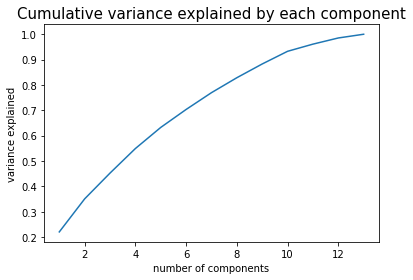

In [30]:
def pca_x(data_train, to_scale, total_comp, var_thresh): 
    data_train = data_train.set_index('track')
    train_tracks_copy = data_train[to_scale].copy()    
    # applying PCA 
    pca = PCA(n_components= total_comp) # from our result in 1.5
    pca.fit(train_tracks_copy)
    # transforming train data 
    x_train_pca = pca.transform(train_tracks_copy)
    # plot pca var explained as function of number of PCs
    plt.plot(np.linspace(1, total_comp, total_comp), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('variance explained')
    plt.title('Cumulative variance explained by each component',fontsize=15)
    optimal = np.where(np.cumsum(pca.explained_variance_ratio_)<=var_thresh)[0]+1
    return x_train_pca

x_train_pca = pca_x(train_tracks_scaled, to_scale, 13, 0.9)

In [31]:
def optimal_pca(data_train, to_scale, optimal_comp):
    data_train = data_train.set_index('track')
    train_tracks_copy = data_train[to_scale].copy()    
    # applying PCA 
    pca = PCA(n_components= optimal_comp) # from our result in 1.5
    pca.fit(train_tracks_copy)
    # transforming data
    optimal_x_pca = pca.transform(train_tracks_copy)
    return optimal_x_pca

optimal_x_pca = optimal_pca(train_tracks_scaled, to_scale, 10)

## Clustering the 100 randomly selected tracks across different playlists
***
After pre-processing our features data via scaling and PCA, we processed with the clustering of the 100 randomly-selected tracks across playlists based on the similiarity of the most important features, i.e. the ones that cumulatively explain about 90% of the variation of the data set.

- ***knn_clustering***
This function fits the training data, calculates the distance between each track as (where the audio features are interpreted as "distances" between tracks), and generates an elbow plot that is helpful to determine k, the optimal number of clusters to be used in our model.

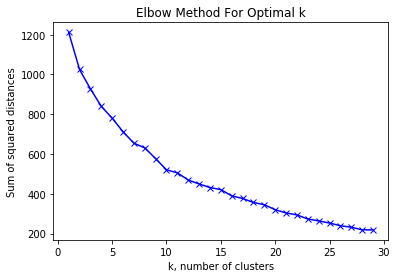

In [38]:
def knn_clustering(pca_train, k_train):
    knn_sum_squared_distances_train = []
    for k in k_train: 
        knn_train = KMeans(n_clusters= k)
        knn_train = knn_train.fit(pca_train)
        knn_sum_squared_distances_train.append(knn_train.inertia_)
    plt.plot(k_train, knn_sum_squared_distances_train, 'bx-')
    plt.xlabel('k, number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return knn_sum_squared_distances_train
k_train = range(1, 30)
cluster_optimal = knn_clustering(optimal_x_pca, k_train)

In [37]:
print(cluster_optimal[10:20])
cluster_optimal[15]

[508.29601759835464, 478.66012661207566, 455.42988212581963, 433.1924769385507, 405.0390458655179, 394.42230803397507, 376.5035667562909, 354.1919104711137, 337.52153447950127, 324.3814147730095]


394.42230803397507

### Generating Optimal k-NN Clusters ###
***

- ***optimal_knn_clustering***
This function clusters the tracks into k clusters, where k in our case was determined based on the elbow plot generated by the knn_clustering function above.

We decided to classify our tracks into 15 clusters by using the elbow plot and observing that 15 clusters significantly reduce the sum of squared distances between tracks while also providing a sensible model. I.e. choosing 100 clusters would simply mean that each track would be the centroid and also the only point in the cluster and although the sume of the squared distance would be 0, the model itself wouldn't be useful in determining the similarity of tracks.

In [39]:
# based on the elbow plot, we pick k number of cluster to be 15
def optimal_knn_clustering(pca_train, k):
        knn_sum_squared_distances_train=[]
        knn_train = KMeans(n_clusters= k)
        knn_train = knn_train.fit(pca_train)
        # predict clusters
        labels = knn_train.predict(pca_train)
        # get cluster centers
        centers = knn_train.cluster_centers_
        return labels, centers

clusters, centers = optimal_knn_clustering(optimal_x_pca, 15)
clusters

array([ 2, 13,  6,  2,  6, 11, 10, 10, 10,  2,  2,  3,  0,  0, 13, 10,  6,
        5,  7, 13, 10,  9,  5,  1, 10,  9,  1,  4,  0, 11,  2,  2, 10,  8,
        8, 11, 10, 12,  1, 10,  8,  5,  2,  2,  2, 10,  1, 10,  2,  1,  1,
        1,  2, 10,  6,  1,  1,  5,  5, 13,  1,  6,  5,  5, 11,  5,  8, 13,
        2, 13, 11, 11,  8,  2, 14, 11,  5,  1, 11,  1,  6,  2, 13,  1,  2,
        1, 10, 10,  2,  1,  2,  8,  3,  1,  8,  2,  1,  1, 13, 11],
      dtype=int32)

### k-NN Clustering Conclusion ###
***

Based on the k-nn clustering model, we can see that the clusters obtained make sense intuitevely -- i.e. songs such as Suavement and Take Your Mama are clustered together -- which having listened to these songs make sense as they do sound similiar without an-indepth analysis of their audio features. An interesting thing to note is that on a few occassions, re-running the k-NN clustering led to different clustering of these tracks, which indicates the instability of this model, which could be caused by the fact that the tracks to be clustered might be similar to more than one of the centroids of the k clusters. Thus, this model manages to cluster tracks based on their audio features' similarity, but is not the most robust and hence, is not the optimal model. 

In [41]:
train_tracks['predicted cluster label'] = clusters.tolist()
train_tracks

,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member,acousticness,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,predicted cluster label
0,1YGa5zwwbzA9lFGPB3HcLt,Suavemente - Spanglish Edit,6hGJXv2n5dNuIpaxpgSBOe,"Suavemente, The Remixes",1c22GXH30ijlOfXhfLz9Df,Elvis Crespo,267333,"92453,112168,121648,238345,245267,303554,31985...",12,0.053100,...,0.000485,8,0.2010,-7.771,1,0.1160,129.244,4,0.8580,2
1,4gOMf7ak5Ycx9BghTCSTBL,Sexo X Money (feat. Ozuna),3BB6mEEVz8vb2yMRSPHiDR,8 Semanas,5gUZ67Vzi1FV2SnrWl1GlE,Benny Benni,278809,"96862,117960",2,0.003360,...,0.000001,4,0.3250,-7.528,0,0.1900,174.046,4,0.8520,13
2,7kl337nuuTTVcXJiQqBgwJ,Jessica - Unedited Version,1n9rbMLUmrXBBBJffS7pDj,Brothers And Sisters,4wQ3PyMz3WwJGI5uEqHUVR,The Allman Brothers Band,451160,"1231,2588,3054,4223,4777,4955,5094,5199,5991,6...",871,0.447000,...,0.854000,2,0.1730,-7.907,1,0.0340,104.983,4,0.8550,6
3,0LAfANg75hYiV1IAEP3vY6,Take Your Mama,65Fllu4vQdZQOh6id0YwIM,Scissor Sisters,3Y10boYzeuFCJ4Qgp53w6o,Scissor Sisters,271906,"1697,2647,3150,5142,5199,6597,6669,7301,7367,7...",534,0.220000,...,0.000018,8,0.0612,-4.542,1,0.1210,153.960,4,0.9330,2
4,0Hpl422q9VhpQu1RBKlnF1,"3rd Chakra ""Sacred Fire""",07fAo1agwL9nuky8VmMhNa,Chakradance,3kbO7dxGm5uux3yrXYlnvR,Jonthan Goldman,509306,231516,1,0.422000,...,0.726000,11,0.1720,-12.959,1,0.0631,130.008,4,0.5180,6
5,4uTTsXhygWzSjUxXLHZ4HW,No Way,1ST1X21yXzG5rJtflnBXFT,The Rise,5Z5jUyiNvFaqp0EVyLNf0p,Futuristic,231823,"1198,2027,3511,5700,6087,6472,9139,10313,12001...",243,0.126000,...,0.000000,4,0.1220,-4.806,0,0.3850,143.988,4,0.1610,11
6,1KDnLoIEPRd4iRYzgvDBzo,Far Away Place,3bcrjy1PXm8vwbqP6ylr6j,On The Quiet,1w7cucUEPR1Yq9g03g6T8m,Xinobi,259146,"460,11131,13976,24479,27781,31117,34279,35995,...",70,0.221000,...,0.294000,0,0.6960,-12.779,1,0.0495,119.003,4,0.1480,10
7,0j9rNb4IHxLgKdLGZ1sd1I,Psalm 145 (Live),3UzKQzSKz9lo1rGBDm7iFv,Psalms Live,2LFbgsbEhfilNpQYW7mied,Shane & Shane,407814,"3716,8758,46215,48732,49280,60327,80056,95633,...",41,0.435000,...,0.000002,4,0.8020,-9.142,0,0.0327,138.494,4,0.2330,10
8,1Dfst5fQZYoW8QBfo4mUmn,Parade,14Q6NvjUSthc0Xgb5EgtQd,Sorry,0W8xe7IqAPlnBRMUpWOUuJ,Meg Myers,205266,"37107,171851,277089,318412,354268,370338,42882...",9,0.221000,...,0.004150,2,0.0879,-9.703,0,0.0270,129.915,4,0.1960,10
9,6ZbiaHwI9x7CIxYGOEmXxd,Beast,1Zx6djdveDkq0CBg3qUZ6N,Beast,4cSYNpczcvTUpnPMFDLsIc,Tungevaag & Raaban,198011,"3107,3744,4350,6324,7592,9519,19093,19323,2265...",84,0.564000,...,0.000000,11,0.2940,-4.607,1,0.1230,160.014,4,0.6030,2


In [ ]:
# note! always close the connection at the end
conn.close()